This is a neural network implement ver of deterministic algorithm.

In [67]:
import os
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Function


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# min(a, b) = a - relu(a - b)
# min(a+1,b)= b - relu(b - a - 1)

#实际上， 只需要5,5，relu，5,3，relu，3,2，relu，2,1 几层即可。
#这个求最小值是针对非负数的。

#参数的trick全在这些数字中，它们构造了最短路算法。
class Kernel(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten()

        #似乎用矩阵结合律还可以压层，不过为了可解释性就不压了。

        self.linear_relu_stack = nn.Sequential()
        self.linear_relu_stack.append(nn.Linear(5, 5, bias=False))
        self.linear_relu_stack[-1].weight.data = torch.tensor([[1,0, 0, 0, 0],[1, -1, 0, 0, 0],[0, 0, 1, 0, 0],[0, 0, 1, -1, 0],[0, 0, 0, 0, 1]], dtype=torch.float32)
        self.linear_relu_stack.append(nn.ReLU())
        self.linear_relu_stack.append(nn.Linear(5, 3, bias=False))
        self.linear_relu_stack[-1].weight.data = torch.tensor([[1,-1,0,0,0],[0,0,1,-1,0],[0,0,0,0,1]], dtype=torch.float32)
        # self.linear_relu_stack.append(nn.ReLU())
        self.linear_relu_stack.append(nn.Linear(3, 3, bias=False))
        self.linear_relu_stack[-1].weight.data = torch.tensor([[1,0, 0],[1, -1, 0],[0, 0, 1]], dtype=torch.float32)
        self.linear_relu_stack.append(nn.ReLU())
        self.linear_relu_stack.append(nn.Linear(3, 2, bias=False))
        self.linear_relu_stack[-1].weight.data = torch.tensor([[1,-1,0],[0,0,1]], dtype=torch.float32)
        # self.linear_relu_stack.append(nn.ReLU())
        self.linear_relu_stack.append(nn.Linear(2, 2))
        self.linear_relu_stack[-1].weight.data = torch.tensor([[0,1],[-1, 1]], dtype=torch.float32)
        self.linear_relu_stack[-1].bias.data = torch.tensor([0,-1], dtype=torch.float32)
        self.linear_relu_stack.append(nn.ReLU())
        self.linear_relu_stack.append(nn.Linear(2, 1, bias=False))
        self.linear_relu_stack[-1].weight.data = torch.tensor([[1,-1]], dtype=torch.float32)

    def forward(self, x):
        # x = self.flatten(x)
        ret = self.linear_relu_stack(x)
        return ret


# model = Kernel().to(device)
# print(model)


class ConvLayer(nn.Module):
    def __init__(self, globalparam):
        super().__init__()
        self.globalparam = globalparam

    def forward(self, x):
        x = F.pad(x, (1, 1, 1, 1), mode='constant', value=10000)
        ret = torch.zeros(28, 28, dtype=torch.float32)
        for i in range(1, 29):
            for j in range(1, 29):
                ret[i-1,j-1] = self.globalparam['kernel'](torch.tensor([[x[i-1,j], x[i,j-1], x[i+1,j], x[i,j+1], x[i,j]]], dtype=torch.float32))
        ret = ret.detach() * self.globalparam['a'] + (1 - self.globalparam['input']) * self.globalparam['b']
        ret = 10000 - nn.ReLU()(10000-ret)
        return ret

class Initializer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # return random select a 1 in matrix x and make it 0, other are 10000
        ret = torch.empty(x.shape).fill_(10000)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if x[i,j] == 1:
                    ret[i,j] = 0
                    return ret
        raise Exception("No 1 in x")

class CloseToMinus1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential()
        self.linear_relu_stack.append(nn.Linear(1, 2))
        self.linear_relu_stack[-1].weight.data = torch.tensor([[1], [-1]], dtype=torch.float32)
        self.linear_relu_stack[-1].bias.data = torch.tensor([0.5, -1.5], dtype=torch.float32)
        self.linear_relu_stack.append(nn.ReLU())
        self.linear_relu_stack.append(nn.Linear(2, 1))
        self.linear_relu_stack[-1].weight.data = torch.tensor([[-10,-10]], dtype=torch.float32)
        self.linear_relu_stack[-1].bias.data = torch.tensor([1], dtype=torch.float32)
        self.linear_relu_stack.append(nn.ReLU())

    def forward(self, x):
        l = torch.tensor([[self.linear_relu_stack(torch.tensor([[i]], dtype=torch.float32)) for i in x]], dtype=torch.float32)
        # x.apply_(self.linear_relu_stack)
        return l

class ExtractNet(nn.Module):
    def __init__(self, globalparam):
        super().__init__()
        self.globalparam = globalparam
        self.linear_relu_stack = nn.Sequential()
        self.linear_relu_stack.append(nn.Linear(5, 4, bias=False))
        self.linear_relu_stack[-1].weight.data = torch.tensor([[1, 0, 0, 0, -1],[0, 1, 0, 0, -1],[0, 0, 1, 0, -1],[0, 0, 0, 1, -1]], dtype=torch.float32)
        
        self.linear_relu_stack2 = nn.Sequential()
        self.linear_relu_stack2.append(nn.Linear(4, 1))
        self.linear_relu_stack2[-1].weight.data = torch.tensor([[1,1,1,1]], dtype=torch.float32)
        self.linear_relu_stack2[-1].bias.data = torch.tensor([-1.5], dtype=torch.float32)
        self.linear_relu_stack2.append(nn.ReLU())


    def forward(self, x):
        # x = self.flatten(x)
        x = F.pad(x, (1, 1, 1, 1), mode='constant', value=10000)
        ret = torch.zeros(28, 28, dtype=torch.float32)
        for i in range(1, 29):
            for j in range(1, 29):
                tmp = self.linear_relu_stack(torch.tensor([x[i-1,j], x[i,j-1], x[i+1,j], x[i,j+1], x[i,j]], dtype=torch.float32))
                b = self.globalparam['close_to_minus_1'](tmp)
                ret[i-1, j-1] = self.linear_relu_stack2(b)
        return ret



# what the GenConv Function do is that it apply Kernel class in input just like Convolution.

gg = {'kernel': Kernel(), 'a': 1, 'b': 10000, 'input': torch.zeros(28, 28, dtype=torch.float32), 'close_to_minus_1': CloseToMinus1()}


class OrNet(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 1-nn.ReLU()(-x.sum()*100+1)
        

class SCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.Initializer = Initializer()
        self.ornet = OrNet()
        self.globalparam = gg
        self.extractnet = ExtractNet(self.globalparam)

    def forward(self, x):
        self.globalparam['input'] = x
        tmp = self.Initializer(x)
        for _ in range (40):
            tmp = ConvLayer(self.globalparam)(tmp)
        return self.ornet(self.extractnet(tmp))

Using cpu device


Test

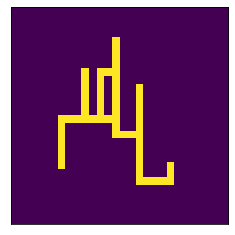

1.0


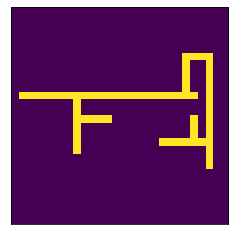

0.0


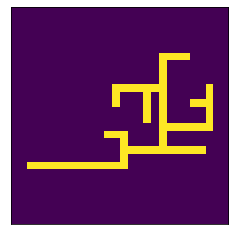

0.0


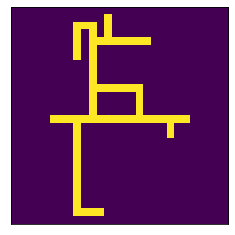

1.0


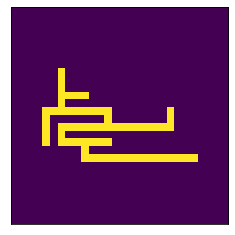

0.0


In [68]:
import numpy as np
import matplotlib.pyplot as plt
cycle_dataset = np.load('cycle_dataset.npz')
train_images = cycle_dataset['train_images']
train_labels = cycle_dataset['train_labels']
test_images = cycle_dataset['test_images']
test_labels = cycle_dataset['test_labels']
def show(X):
    '''
    Changing inf to 40 can get a picture with more detail.
    '''
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if X[i,j] > 1000:
                X[i,j] = 40
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X)
    plt.show()

model = SCNN()
for i in range(10,15):
    demoinput = test_images[i]
    show(test_images[i])
    print(model(demoinput).item())